In [50]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds

from delfi.simulator.BaseSimulator import BaseSimulator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import colorcet as cc
import numpy as np
from delfi.utils.viz import plot_pdf

from tqdm import tqdm_notebook as tqdm

from parameters import ParameterSet

%matplotlib notebook

In [2]:
class ShapeModel(BaseSimulator):
    def __init__(self, f, sigma, ndim, seed=None):
        super().__init__(dim_param=ndim, seed=seed)
        self.f = f
        
        self.sigma = sigma
        
    def gen_single(self, params):
        m = self.f(params)
        draw = self.rng.normal(loc=m, scale=self.sigma, size=(1,))
        return { 'data' : draw }
    
class ShapeDistribution(dd.BaseDistribution.BaseDistribution):
    def __init__(self, f, sm, obs_stats, seed=None):
        super().__init__(sm.dim_param, seed=seed)
        self.f = f
        self.sm = sm
        self.obs_stats = obs_stats
        self.m = np.linalg.norm(obs_stats)
        self.sigma = sm.sigma
        
    def eval(self, params, log=True):
        logl = -0.5 * np.log(2 * np.pi * self.sigma) -0.5 * ([self.f(param) for param in params] - self.m) ** 2 / (self.sigma ** 2)
        return logl if log else np.exp(logl)

In [91]:
def plot_pdf_2d(params, dist, label = None, flat=False):
    lims = 2 * np.linalg.norm(params.obs_stats)
    fig = plt.figure(figsize=(8,4))
   
    if flat:
        xlist = np.linspace(-lims, lims, 800)
        ylist = np.linspace(-lims, lims, 800)
    
        ax = fig.add_subplot(111)
    else:
        xlist = np.linspace(-lims, lims, 100)
        ylist = np.linspace(-lims, lims, 100)
    
        ax = fig.add_subplot(111, projection='3d')
    
    X, Y = np.meshgrid(xlist, ylist)
    xys = np.asarray((X.ravel(), Y.ravel())).T
    
    if label is not None:
        fig.suptitle(label)
        
    Z = dist.eval(xys, log=False).reshape(X.shape)
    
    if flat:
        ax.pcolormesh(X, Y, Z, cmap=cc.cm['linear_bmy_10_95_c71'])
    else:
        ax.plot_surface(X, Y, Z, cmap=cc.cm['linear_bmy_10_95_c71'], rstride=1, cstride=1, linewidth=0, antialiased=False)
        ax.set_zlabel("$p(\\theta)$")
        
    ax.set_xlabel("$\\theta_1$")
    ax.set_ylabel("$\\theta_2$")
    plt.show()
    
    return fig

In [9]:
def run_SNPE(params):
    m = ShapeModel(params.f, sigma=params.sigma, ndim=params.ndim, seed=params.seed)
    p = dd.Uniform(-params.prior_width * np.ones(params.ndim), params.prior_width * np.ones(params.ndim), seed=params.seed)
    s = ds.Identity(1)
    g = dg.Default(model=m, prior=p, summary=s)

    gt = ShapeDistribution(params.f, m, params.obs_stats, seed=params.seed)
    
    res = infer.SNPE(g, obs=[params.obs_stats], 
                     n_hiddens=params.n_hiddens, 
                     n_components=params.n_components, 
                     seed=params.seed, 
                     prior_mixin=params.prior_mixin, 
                     verbose=True)
    
    res.run(n_train=params.n_train, n_rounds = params.n_rounds, round_cl=1)

    return m, p, s, res, gt

In [108]:
default_params = ParameterSet({})

default_params.seed = 394
default_params.ndim = 2
default_params.n_components = 10
default_params.n_hiddens = [ default_params.n_components * default_params.ndim * 10 ]

default_params.sigma = 0.2

default_params.true_params = 2 * np.eye(default_params.ndim)[0]
default_params.obs_stats = [np.linalg.norm(default_params.true_params)]
default_params.prior_width = 2

default_params.prior_mixin = 0.1

default_params.n_train = 50000
default_params.n_rounds = 3

cubic = lambda x: (x[0] - 2) * (x[0] + 2) * x[0] - x[1] + 1
ushape = lambda x: x[0] ** 2 - x[1]
ring = np.linalg.norm
default_params.f = ring

default_params.n_qtest = 10000

In [109]:
model, prior, summ, net, gt = run_SNPE(default_params)

<IPython.core.display.Javascript object>


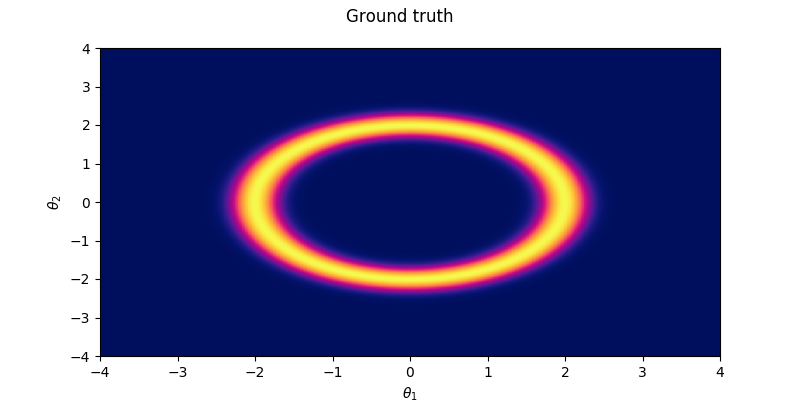

<IPython.core.display.Javascript object>


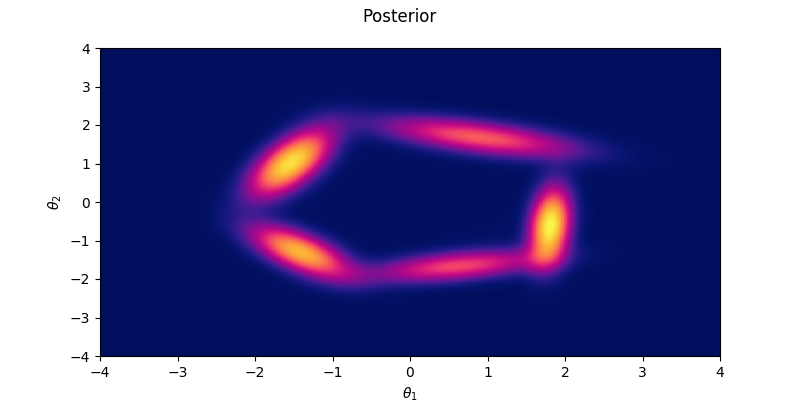

In [101]:
plot_pdf_2d(default_params, gt, "Ground truth", flat=True);

posterior = net.predict([default_params.obs_stats])
plot_pdf_2d(default_params, posterior, "Posterior", flat=True);

In [103]:
def estimate_quantile(model, prior, summ, net, i=0, L=1000):
    theta = prior.gen()[0]
    y = model.gen_single(theta)
    stats = summ.calc([y])
    
    posterior = net.predict(stats)
    
    post_thetas = posterior.gen(n_samples=L)
    
    est_quantile = 1 / L * np.count_nonzero(theta[i] > post_thetas[:,i])
    return est_quantile

In [104]:
quantiles = []

for i in tqdm(range(default_params.n_qtest)):
    quantiles.append(estimate_quantile(model, prior, summ, net, i=0))

<IPython.core.display.Javascript object>


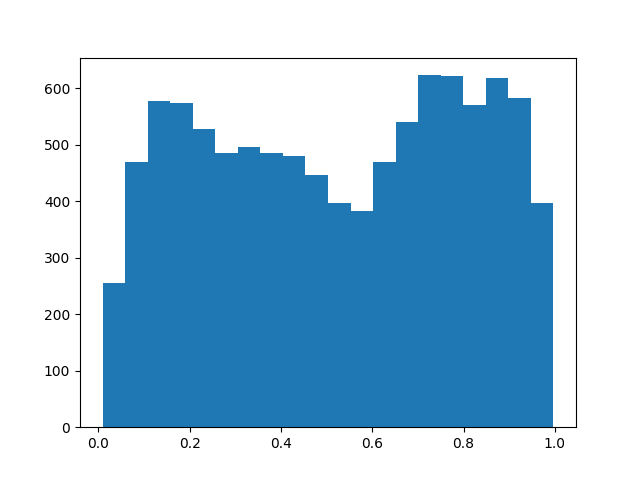

In [105]:
fig = plt.figure()
ax = plt.subplot(111)

ax.hist(quantiles, bins=20)

plt.show()

<IPython.core.display.Javascript object>


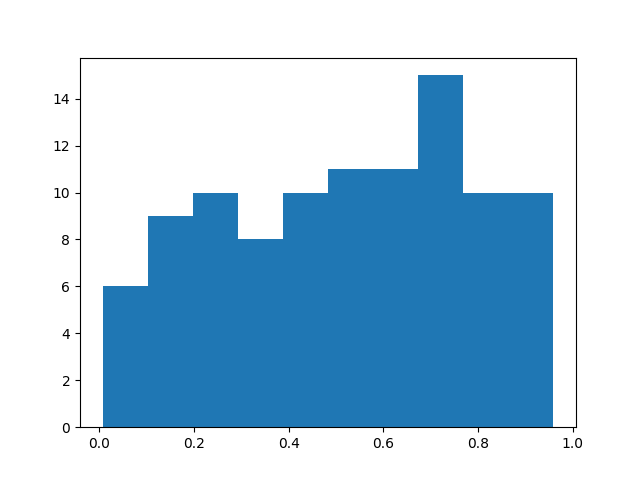

In [110]:
samples = np.random.uniform(0, 1, size=100)

fig = plt.figure()
ax = plt.subplot(111)

ax.hist(samples)

plt.show()